In [30]:
from pathlib import Path
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MaxAbsScaler, MinMaxScaler, Normalizer, PolynomialFeatures, RobustScaler, StandardScaler

from imblearn.combine import SMOTEENN

import mlflow

random_seed = 42
np.random.seed(random_seed)

In [2]:
DATA_DIR = Path('./data/phase-1')
DATA_DIR = DATA_DIR / 'prob-1'

In [3]:
df_train = pd.read_parquet(DATA_DIR / 'raw_train.parquet', engine='fastparquet')
df_description = pd.read_csv(DATA_DIR / 'description.csv')

In [4]:
with open(DATA_DIR / 'features_config.json') as file:
    features_cfg = json.load(file)

In [5]:
def trial(solution_pipeline, X, y, n_folds=5):
    scores = {}

    kf = KFold(n_splits=n_folds)
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        solution_pipeline.fit(X_train, y_train)
        score = solution_pipeline.score(X_val, y_val)
        for s in score.keys():
            if s not in scores.keys():
                scores[s] = []
            scores[s].append(score[s])
            
    
    scores_df = pd.DataFrame({
        'model': scores.keys(),
        'mean': [np.mean(scores[name_model]) for name_model in scores],
        'std': [np.std(scores[name_model]) for name_model in scores]
     }).sort_values(by=['mean', 'std'], ascending=False)
    
    return scores_df

# 1. PROBLEM 1

In [6]:
df_description

,Key,Value
0,Source,MLOps
1,Label,is Fraud (1) or Not (0)
2,Train size,134201
3,Test size,297945
4,Description,The ML problem at hand involves predicting fra...


In [7]:
df_description.loc[df_description['Key'] == 'Description', 'Value'].values[0]

"The ML problem at hand involves predicting fraudulent transactions in a financial dataset. The target variable is 'label', which is a binary variable indicating whether a transaction is fraudulent or not."

In [8]:
df_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,label,feature14,feature15,feature16
0,Site engineer,grocery_pos,8.60,48230,40.213439,-85.203756,47583,42.508293,-83.168004,65.596062,3,5,1,1,8.017865,1.028822,58.911132
1,Site engineer,gas_transport,316.84,48230,44.379391,-82.859721,47583,42.661838,-81.966510,64.728795,6,5,1,1,11.768568,1.106217,64.431017
2,Site engineer,grocery_pos,294.89,48230,42.950657,-84.935542,47583,42.580470,-82.408529,65.434606,3,5,1,1,7.996359,0.899881,57.545348
3,Site engineer,shopping_net,831.08,48230,39.372111,-84.893973,47583,41.948688,-83.919881,64.990422,23,6,1,1,8.767720,1.062966,62.681169
4,Site engineer,health_fitness,1063.84,48230,41.227499,-83.228392,47583,41.544743,-82.123365,65.316083,23,6,1,1,8.816222,0.722446,63.084486


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134201 entries, 0 to 134200
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   feature1   134201 non-null  object 
 1   feature2   134201 non-null  object 
 2   feature3   134201 non-null  float64
 3   feature4   134201 non-null  int64  
 4   feature5   134201 non-null  float64
 5   feature6   134201 non-null  float64
 6   feature7   134201 non-null  int64  
 7   feature8   134201 non-null  float64
 8   feature9   134201 non-null  float64
 9   feature10  134201 non-null  float64
 10  feature11  134201 non-null  int64  
 11  feature12  134201 non-null  int64  
 12  feature13  134201 non-null  int64  
 13  label      134201 non-null  int64  
 14  feature14  134201 non-null  float64
 15  feature15  134201 non-null  float64
 16  feature16  134201 non-null  float64
dtypes: float64(9), int64(6), object(2)
memory usage: 17.4+ MB


In [10]:
# Số lượng giá trị NaN

df_train.isna().sum()

feature1     0
feature2     0
feature3     0
feature4     0
feature5     0
feature6     0
feature7     0
feature8     0
feature9     0
feature10    0
feature11    0
feature12    0
feature13    0
label        0
feature14    0
feature15    0
feature16    0
dtype: int64

**Kết luận**: Không có giá trị NaN

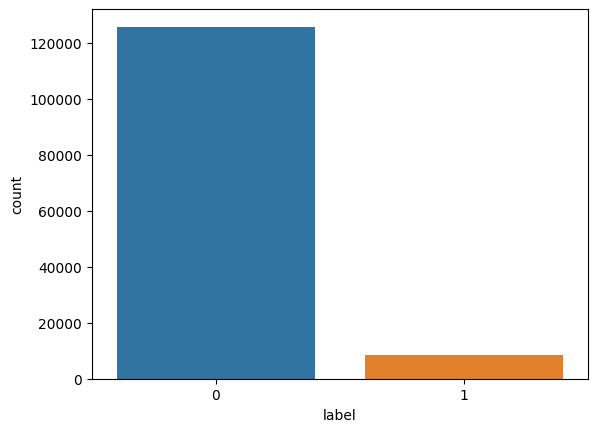

In [11]:
sns.countplot(data=df_train, x='label')
plt.show()

**Kết luận**: Target bị mất cân bằng

# 1.1. Prepare data

In [12]:
target_column = features_cfg['target_column']
category_columns = features_cfg['category_columns']
numeric_columns = features_cfg['numeric_columns']

In [13]:
X = df_train.copy()
y = X.pop(target_column)

## 1.2. Define models

In [14]:
class BaselineModels:
    
    def __init__(self, random_state=42):
        self.random_state=random_state
        self.baseline_models = {
            # 'linear_model': LogisticRegression(),
            # 'decision_tree': DecisionTreeClassifier(random_state=self.random_state),
            # 'random_forest': RandomForestClassifier(random_state=self.random_state),
            # 'xgb': XGBClassifier(random_state=self.random_state, tree_method='gpu_hist'),
            'lightgbm': LGBMClassifier(random_state=self.random_state, verbose=-1, device='gpu'),
            # 'catboost': CatBoostClassifier(random_state=self.random_state, verbose=False, task_type='GPU')
        }
        
    def fit(self, X_train, y_train):
        for model in self.baseline_models:
            self.baseline_models[model].fit(X_train, y_train)
        return self
    
    def predict(self, X_test):
        preds = {}
        for model in self.baseline_models:
            y_pred = self.baseline_models[model].predict(X_test)
            preds[model] = y_pred
        return preds
    
    def score(self, X_test, y_test):
        scores = {}
        for model in self.baseline_models:
            y_pred = self.baseline_models[model].predict(X_test)
            scores[model] = f1_score(y_test, y_pred)
        return scores

## 1.3. Solutions

### 1.3.1. Drop categorical features

In [38]:
class DropFeatureTransformer():
    
    def __init__(self, cols=[]):
        self.cols = cols

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.cols, axis=1).copy()

In [39]:
solution_1_pipeline = Pipeline([
    ('drop_categorical_feature', DropFeatureTransformer(cols=category_columns)),
    ('baseline_models', BaselineModels(random_state=random_seed))
])

In [40]:
trial(solution_1_pipeline, X, y)

d:\MLOps-Marathon-2023\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,mean,std
0,linear_model,0.588764,0.074366
1,decision_tree,0.875349,0.032968
2,random_forest,0.920087,0.029958
4,lightgbm,0.936643,0.019072
3,xgb,0.936985,0.019338
5,catboost,0.940917,0.017850


In [14]:
def print_auto_logged_info(run):
    tags = {k: v for k, v in run.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [
        f.path for f in mlflow.MlflowClient().list_artifacts(run.info.run_id, "model")
    ]
    feature_importances = [
        f.path
        for f in mlflow.MlflowClient().list_artifacts(run.info.run_id)
        if f.path != "model"
    ]
    print(f"run_id: {run.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"feature_importances: {feature_importances}")
    print(f"params: {run.data.params}")
    print(f"metrics: {run.data.metrics}")
    print(f"tags: {tags}")

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
OH_X_train = pd.DataFrame(encoder.fit_transform(X_train[category_columns]))
OH_X_val = pd.DataFrame(encoder.transform(X_val[category_columns]))
OH_X_train.columns = [str(col) + '_cat' for col in OH_X_train.columns]
OH_X_val.columns = [str(col) + '_cat' for col in OH_X_val.columns]

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train[numeric_columns])
scaled_X_val = scaler.transform(X_val[numeric_columns])

poly = PolynomialFeatures(2)
poly_X_train = pd.DataFrame(poly.fit_transform(scaled_X_train))
poly_X_val = pd.DataFrame(poly.transform(scaled_X_val))

X_train = pd.concat([OH_X_train, poly_X_train], axis=1)
X_val = pd.concat([OH_X_val, poly_X_val], axis=1)

model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')
mlflow.lightgbm.autolog()

with mlflow.start_run() as run:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
    score = auc(fpr, tpr)
    mlflow.log_metric('auc', score)

In [20]:
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

run_id: d97d6d0f63984aee8896380e5b683318
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/model.pkl', 'model/python_env.yaml', 'model/requirements.txt']
feature_importances: ['feature_importance_gain.json', 'feature_importance_gain.png', 'feature_importance_split.json', 'feature_importance_split.png']
params: {'boosting_type': 'gbdt', 'categorical_feature': 'auto', 'colsample_bytree': '1.0', 'device': 'gpu', 'early_stopping_rounds': 'None', 'evals_result': 'None', 'feature_name': 'auto', 'keep_training_booster': 'False', 'learning_rate': '0.1', 'max_depth': '-1', 'metric': "['binary']", 'min_child_samples': '20', 'min_child_weight': '0.001', 'min_split_gain': '0.0', 'num_boost_round': '100', 'num_leaves': '31', 'n_jobs': '-1', 'objective': 'binary', 'random_state': '42', 'reg_alpha': '0.0', 'reg_lambda': '0.0', 'subsample': '1.0', 'subsample_for_bin': '200000', 'subsample_freq': '0', 'verbose': '-1', 'verbose_eval': 'warn'}
metrics: {'auc': 0.9704341352575249}
tags: {}


In [24]:
model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')
model.fit(X_train, y_train)

LGBMClassifier(device='gpu', random_state=42, verbose=-1)

In [27]:
y_pred = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
score = auc(fpr, tpr)

In [47]:
y_prob = model.predict_proba(X_val)
a = []
for i in np.arange(0, 1, 0.001):
    y_pred = []
    for j in y_prob:
        if (j[0] > i):
            y_pred.append(0)
        else:
            y_pred.append(1)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
    a.append(auc(fpr, tpr))

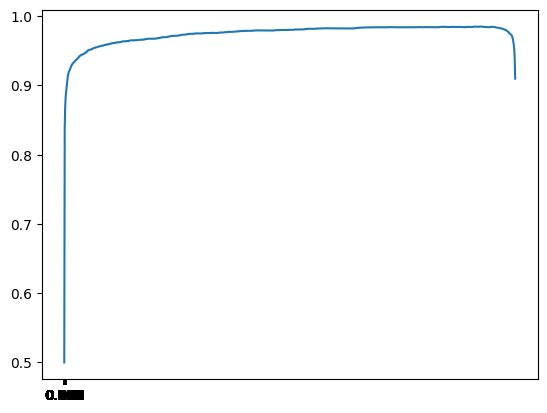

In [50]:
plt.plot(a)
plt.xticks(np.arange(0, 1, 0.001))
plt.show()

In [20]:
def trial(X, y, n_folds=5):
    scores = []

    kf = KFold(n_splits=n_folds)
    for idx, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f'Fold: {idx + 1}')

        smote_enn = SMOTEENN(random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

        encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        OH_X_train = pd.DataFrame(encoder.fit_transform(X_train[category_columns]))
        OH_X_val = pd.DataFrame(encoder.transform(X_val[category_columns]))
        OH_X_train.columns = [str(col) + '_cat' for col in OH_X_train.columns]
        OH_X_val.columns = [str(col) + '_cat' for col in OH_X_val.columns]
        
        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train[numeric_columns])
        scaled_X_val = scaler.transform(X_val[numeric_columns])
        
        poly = PolynomialFeatures(2)
        poly_X_train = pd.DataFrame(poly.fit_transform(scaled_X_train))
        poly_X_val = pd.DataFrame(poly.transform(scaled_X_val))
        
        X_train = pd.concat([OH_X_train, poly_X_train], axis=1)
        X_val = pd.concat([OH_X_val, poly_X_val], axis=1)

        X_train.columns = X_train.columns.astype(str)
        X_val.columns = X_val.columns.astype(str)

        X_train, y_train = smote_enn.fit_resample(X_train, y_train)

        model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
        scores.append(auc(fpr, tpr))
    
    return scores

In [21]:
scores = trial(X, y)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [22]:
scores

[0.9798847800633483,
 0.9807182738438411,
 0.9807182738438411,
 0.9807182738438411,
 0.9807182738438411]

In [15]:
mlflow.autolog()

2023/06/26 17:49:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/06/26 17:49:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/06/26 17:49:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [34]:
smote_enn = SMOTEENN(random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
OH_X_train = pd.DataFrame(encoder.fit_transform(X_train[category_columns]))
OH_X_val = pd.DataFrame(encoder.transform(X_val[category_columns]))
OH_X_train.columns = [str(col) + '_cat' for col in OH_X_train.columns]
OH_X_val.columns = [str(col) + '_cat' for col in OH_X_val.columns]

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train[numeric_columns])
scaled_X_val = scaler.transform(X_val[numeric_columns])

poly = PolynomialFeatures(2)
poly_X_train = pd.DataFrame(poly.fit_transform(scaled_X_train))
poly_X_val = pd.DataFrame(poly.transform(scaled_X_val))

X_train = pd.concat([OH_X_train, poly_X_train], axis=1)
X_val = pd.concat([OH_X_val, poly_X_val], axis=1)

X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)

model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
print(auc(fpr, tpr))

0.9701828204746994


In [ ]:
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
score = auc(fpr, tpr)
mlflow.log_metric('auc', score)
print(score)

2023/06/26 18:26:40 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/06/26 18:26:40 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/06/26 18:26:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [41]:
def objective(trial, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 2, 8000),
        'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
        'tree_learner': trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting']),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 40),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 0.0001, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.001, 1),
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.001, 1),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.001, 1),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 30),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynod', 0, 1),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'linear_lambda': trial.suggest_float('linear_lambda', 0, 1),
        'max_delta_step': trial.suggest_int('max_delta_step', -1, 15),
        'min_gain_to_split': trial.suggest_int('min_gain_to_split', 0, 30),
        'verbose': -1
    }

    model = LGBMClassifier(**params, objective='binary', device_type='gpu', random_state=42, early_stopping_round=300, verbose_eval=False)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgbm.log_evaluation(0)])
    
    y_pred = model.predict(X_val)

    fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
    score = auc(fpr, tpr)
    return score

In [ ]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
params = {'learning_rate': 0.2486410439277429, 'n_estimators': 7452, 'num_leaves': 849, 'tree_learner': 'voting', 'max_depth': 5, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 0.8955809728109798, 'bagging_fraction': 0.09043905511382372, 'pos_bagging_fraction': 0.9012054185024574, 'neg_bagging_fraction': 0.7865520573440599, 'bagging_freq': 13, 'feature_fraction': 0.7319641299117381, 'feature_fraction_bynode': 0.9241064494822343, 'extra_trees': False, 'lambda_l1': 0.2446767921786603, 'linear_lambda': 0.2943466035061232, 'max_delta_step': 4, 'min_gain_to_split': 1}

model = LGBMClassifier(**params, objective='binary', device_type='gpu', random_state=42, early_stopping_round=300, verbose_eval=False)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgbm.log_evaluation(0)])

In [ ]:
y_pred = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
print(auc(fpr, tpr))

In [51]:
import pickle

f = open('model.sav','wb')
pickle.dump(model, f)
f.close()

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42)

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
OH_X_train = pd.DataFrame(encoder.fit_transform(X_train[category_columns]))
OH_X_val = pd.DataFrame(encoder.transform(X_val[category_columns]))
OH_X_train.columns = [str(col) + '_cat' for col in OH_X_train.columns]
OH_X_val.columns = [str(col) + '_cat' for col in OH_X_val.columns]

scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]))
scaled_X_val = pd.DataFrame(scaler.transform(X_val[numeric_columns]))

# poly = PolynomialFeatures(2)
# poly_X_train = pd.DataFrame(poly.fit_transform(scaled_X_train))
# poly_X_val = pd.DataFrame(poly.transform(scaled_X_val))

# X_train = pd.concat([OH_X_train, poly_X_train], axis=1)
# X_val = pd.concat([OH_X_val, poly_X_val], axis=1)

X_train = pd.concat([OH_X_train, scaled_X_train], axis=1)
X_val = pd.concat([OH_X_val, scaled_X_val], axis=1)

X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)

model = LGBMClassifier(random_state=42, verbose=-1, device='gpu')

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred, pos_label=1)
print(auc(fpr, tpr))

0.9721296991916879


In [37]:
import tensorflow as tf

In [38]:
X_train = tf.convert_to_tensor(X_train)

In [40]:
X_val = tf.convert_to_tensor(X_val)

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.AUC(from_logits=True)])

In [43]:
model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=[X_val, y_val])

Epoch 1/15
197/197 [==============================] - 2s 4ms/step - loss: 0.2322 - auc: 0.9097 - val_loss: 0.0640 - val_auc: 0.9871
Epoch 2/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0539 - auc: 0.9889 - val_loss: 0.0493 - val_auc: 0.9888
Epoch 3/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0454 - auc: 0.9892 - val_loss: 0.0459 - val_auc: 0.9882
Epoch 4/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0416 - auc: 0.9901 - val_loss: 0.0435 - val_auc: 0.9882
Epoch 5/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0385 - auc: 0.9910 - val_loss: 0.0416 - val_auc: 0.9889
Epoch 6/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0358 - auc: 0.9919 - val_loss: 0.0398 - val_auc: 0.9897
Epoch 7/15
197/197 [==============================] - 1s 4ms/step - loss: 0.0333 - auc: 0.9935 - val_loss: 0.0374 - val_auc: 0.9904
Epoch 8/15
197/197 [==============================] - 1s 4ms/step - loss: 0.

In [44]:
model.save('my_model.h5')

In [58]:
model.predict(X_train, verbose=0)

array([[-10.733581],
       [ -9.498124],
       [-13.819621],
       ...,
       [ -7.508799],
       [ -8.045641],
       [-10.197067]], dtype=float32)

In [56]:
X_train[0].numpy().shape

(507,)